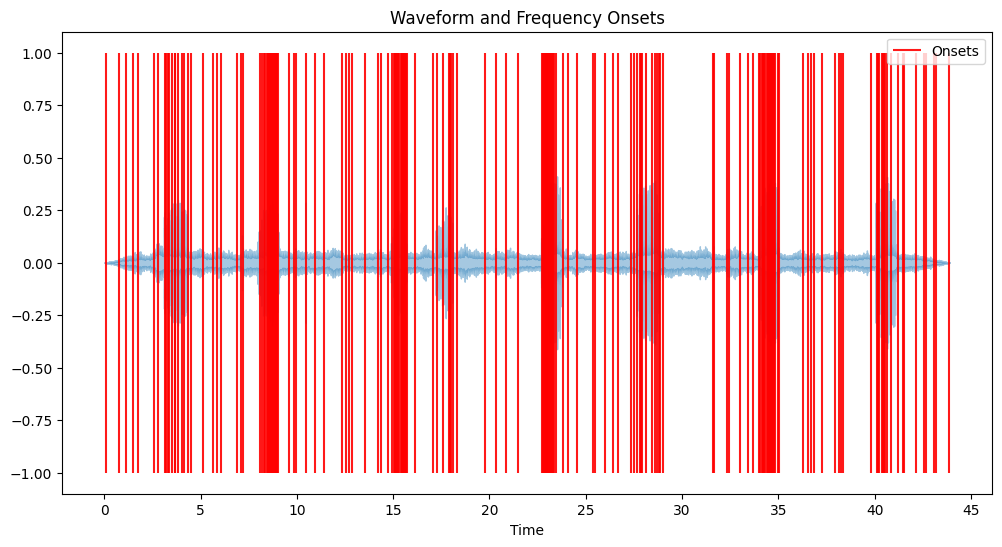

In [9]:
import librosa
import numpy as np
import pywt
import matplotlib.pyplot as plt

audio_path = 'Celeus elegans.mp3'  
audio, sr = librosa.load(audio_path)

# Detect onsets
CQT = np.abs(librosa.cqt(audio, sr=sr))
onset_env = librosa.onset.onset_strength(S=librosa.amplitude_to_db(CQT), sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)  
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
offset_times = onset_times[1:].tolist() + [librosa.get_duration(y=audio, sr=sr)]
segment_times = list(zip(onset_times, offset_times))

segment_samples = [(librosa.time_to_samples(start, sr=sr), librosa.time_to_samples(end, sr=sr)) for start, end in segment_times]
plt.figure(figsize=(12, 6))
librosa.display.waveshow(audio, sr=sr, alpha=0.4)
plt.vlines(onset_times, -1, 1, color='r', alpha=0.9, label='Onsets')

plt.legend(loc='upper right')
plt.title("Waveform and Frequency Onsets")
plt.show()

def extract_mfcc_and_wavelet_features(audio, sr, n_mfcc=13, wavelet='db4', max_level=5, wavelet_feature_size=1000):
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    
    # Compute Wavelet Transform and flatten
    coeffs = pywt.wavedec(audio, wavelet, level=max_level)
    wavelet_features_flat = np.concatenate([c.ravel() for c in coeffs[:max_level]])
    
    # Ensure wavelet features are of a fixed size
    if len(wavelet_features_flat) > wavelet_feature_size:
        # Truncate if too long
        wavelet_features_flat = wavelet_features_flat[:wavelet_feature_size]
    else:
        # Zero-pad if too short
        wavelet_features_flat = np.pad(wavelet_features_flat, (0, wavelet_feature_size - len(wavelet_features_flat)), 'constant')
    
    # Combine MFCCs and wavelet features
    mfccs_aggregated = np.mean(mfccs, axis=1)  # Mean across time frames
    mfccs_std = np.std(mfccs, axis=1)  # Standard deviation across time frames
    aggregated_features = np.concatenate((mfccs_aggregated, mfccs_std, wavelet_features_flat))
    
    return aggregated_features


def aggregate_features(mfccs, wavelet_features):
    # Aggregating MFCC features
    mfccs_aggregated = np.mean(mfccs, axis=1)  # Mean across time frames
    mfccs_std = np.std(mfccs, axis=1)  # Standard deviation across time frames
    
    # Combine aggregated features
    aggregated_features = np.concatenate((
        mfccs_aggregated, mfccs_std, 
        wavelet_features))
    
    return aggregated_features

def process_audio_segments(audio, sr, segment_samples):
    features = []
    for onset, offset in segment_samples:
        segment = audio[onset:offset]
        aggregated_features = extract_mfcc_and_wavelet_features(segment, sr, n_mfcc=13, wavelet='db4', max_level=5, wavelet_feature_size=100)
        features.append(aggregated_features)
    
    # Now, features should be an array where each row is a feature vector of consistent length
    return np.vstack(features)

/opt/homebrew/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1025
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1023
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=2047
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1600
  warnings.warn(
/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppres

Optimal number of clusters: 8, with a silhouette score of: 0.11768500506877899


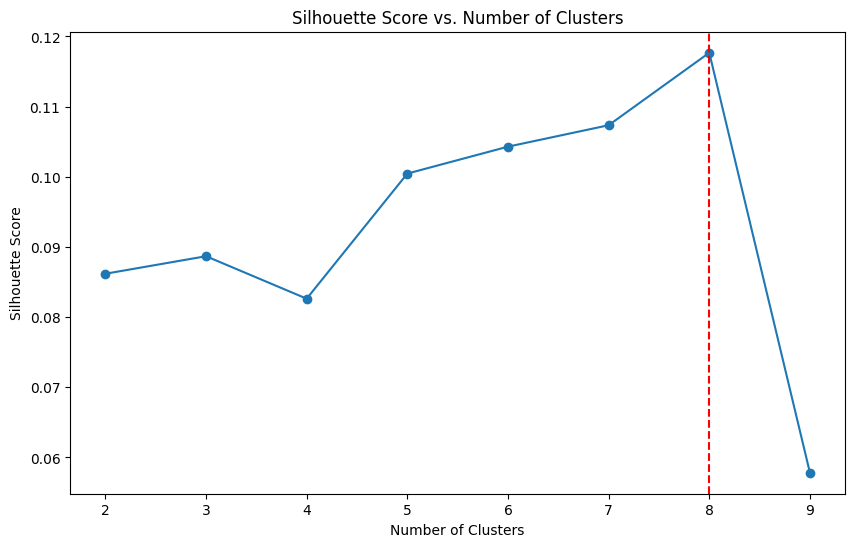

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


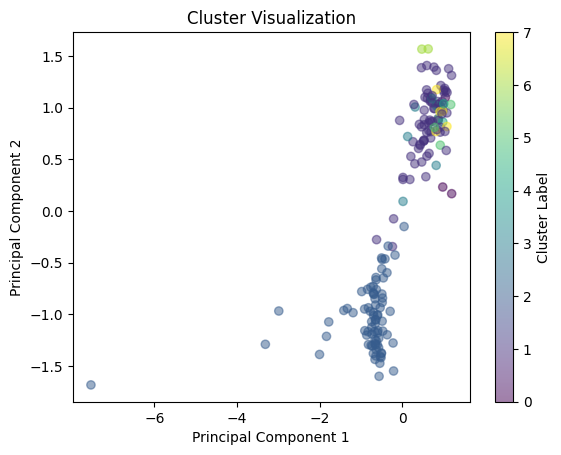

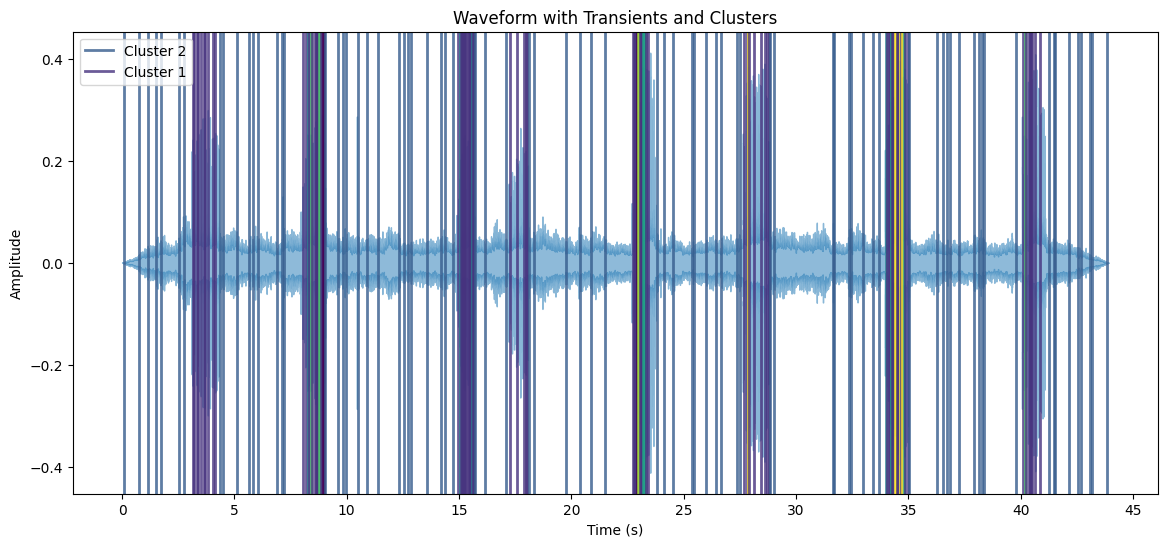

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = process_audio_segments(audio, sr, segment_samples)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)
pca = PCA(n_components=0.95)  # Retain 95% of variance
features_reduced = pca.fit_transform(features_scaled)

from sklearn.metrics import silhouette_score

min_cluster = 2  # Starting with at least 2 clusters (silhouette score isn't defined for 1 cluster)
max_cluster = 10  # Adjust based on dataset and computational resources (10 is usually plenty)

# Ensuring consistency by using the same dataset for silhouette scores and KMeans
silhouette_scores = [silhouette_score(features_scaled, KMeans(n_clusters=i, random_state=42).fit_predict(features_scaled)) for i in range(min_cluster, max_cluster)]

# Find the optimal number of clusters
optimal_n_clusters = min_cluster + np.argmax(silhouette_scores)
optimal_score = silhouette_scores[np.argmax(silhouette_scores)]

print(f"Optimal number of clusters: {optimal_n_clusters}, with a silhouette score of: {optimal_score}")

# Plotting the silhouette scores can help visualize how cluster coherence changes
plt.figure(figsize=(10, 6))
plt.plot(range(min_cluster, max_cluster), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.axvline(x=optimal_n_clusters, linestyle='--', color='red')
plt.show()

n_clusters = min_cluster + np.argmax(silhouette_scores)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(features_scaled)


plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization')
plt.colorbar(label='Cluster Label')
plt.show()


plt.figure(figsize=(14, 6))
librosa.display.waveshow(audio, sr=sr, alpha=0.5)
plt.title('Waveform with Transients and Clusters')

# Get unique cluster labels
unique_labels = set(labels)

# Create a colormap, one color for each cluster
colors = plt.cm.get_cmap('viridis', len(unique_labels))

# Mark the transients, color-coded by cluster
for i, (time, label) in enumerate(zip(onset_times, labels)):
    plt.axvline(x=time, color=colors(label), linewidth=2, alpha=0.8, label=f'Cluster {label}' if i in unique_labels else "")

# Optional: Make the legend only show one entry per cluster
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()